In [1]:
%matplotlib inline

In [2]:
# set seed before everything else
#np.random.seed(0)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [4]:
def heaviside(t):
    return 1 if t >= 0 else 0

def sample_k_slopes(num, p, mean1, stdev1, mean2, stdev2):
    return np.random.normal(mean1, stdev1, num) if np.random.uniform() >= p else np.random.normal(mean2, stdev2, num)

def sample_v_slopes(num, mean, stdev):
    return np.random.normal(mean, stdev, num)


In [5]:
# constants for the simulation

# therapeutic goals
peak_goal = 7
trough_goal = 1.5

# patient elimination parameters
k_int = 0.01
k_slope = 0.003125
cl_cr = 50

# patient volume parameters
v_slope = 0.2806
bw = 70

# elimation rate and volume of distribution
k_el = k_int + cl_cr * k_slope
v_d = v_slope * bw

k_slopes = sample_k_slopes(9, 0.2, 4/3*k_slope, 0.001, 2/3*k_slope, 0.001)
v_slopes = sample_v_slopes(9, 0.2806, 0.05)

dosage_period = 12 # 
duration = 1500 # duration of simulation in hours

days = duration//24
dose_change_interval = days//3

# dose changes every three days so this continues the trend further
# the only real purpose for continuing the simulation past ten days is for debugging
# it lets us see if the dose optimization is actually converging to the correct value
dose_changes = [72*i+12 for i in range(dose_change_interval)]

# measurement times are a little more difficult, it's essentially two patterns interspersed
# so we simply create each pattern, put them together, and then sort them
measurement_times = sorted([72*i for i in range(dose_change_interval)] + [72*i+11 for i in range(dose_change_interval)])

# error variances, the values can't be too small, otherwise we will get NaN values
# however the variances can be set small enough to have insignifant effect on the simulation
# debugging is the main reason for this purpose
observation_error = 0.5
dosage_error = 0.01
timing_error = 0.01

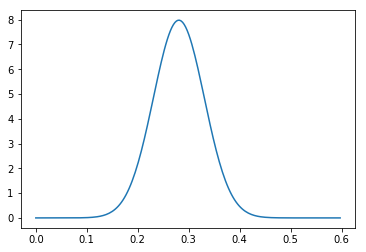

In [6]:
ts = [ i*0.003 for i in range(200) ]
fit = st.norm.pdf(ts, v_slope, 0.05)
plt.plot(ts, fit)

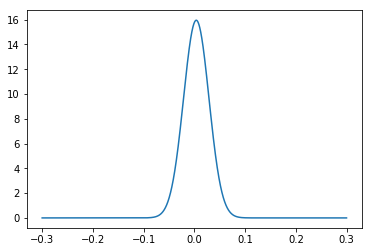

In [7]:
ts = [ i*0.00003 for i in range(-10000,10000) ]

fit1 = st.norm.pdf(ts, (4/3)*k_slope, 0.025)
fit2 = st.norm.pdf(ts, (2/3)*k_slope, 0.025)

#plt.hist(sample_k_slopes(100000, 0.2, 4/3*k_slope, 0.001, 2/3*k_slope, 0.001))
plt.plot(ts, 0.8*fit1+0.2*fit2)


In [8]:
# starting assertions

# the peak should be greater than the trough
assert peak_goal > trough_goal
# make sure there are two measurements per dose change
assert len(dose_changes) * 2 == len(measurement_times)

In [9]:
class DrugSimulator:
    def __init__(self):
        global dosage_period, duration
        
        # the times that the doses will be administered
        self.dose_times = list(filter(lambda t: t % dosage_period == 0, range(duration)))
        # where taken measurements will be stored
        self.measurements = []

        # initialize dosage and prior matrix
        self.prior = self.initialize_prior()
        self.current_dosage = self.initialize_dosage(0, 11)

        self.doses_across = [self.current_dosage]
        self.doses_within = []
        
        # set initial condition
        self.init = 0

    def initialize_prior(self):
        ''' Initializes our Bayesian prior '''

        global k_slopes, v_slopes
        global cl_cr, k_int, bw
        
        # create a matrix of zeroes
        prior = [ [ 0 for i in range(len(v_slopes)) ] for j in range(len(k_slopes)) ]
        # initially set each model to have the same weight
        # TODO: initialize each model to have a distinct weight
        w = 1/(len(k_slopes) * len(v_slopes))
        
        for i in range(len(prior)):
            for j in range(len(prior[0])):
                # set each element of the matrix to triples
                # each containing the weight, the elimination rate
                # and the volume of distribution
                prior[i][j] = (w, k_slopes[i]*cl_cr+k_int, v_slopes[j]*bw)

        return prior

    def initialize_dosage(self, tp, tt):
        ''' Calculates the optimal initial dosage '''

        dose = 0

        for i in range(len(self.prior)):
            for j in range(len(self.prior[0])):
                # unpack the values of the triple
                w, k, v = self.prior[i][j]

                # add the weighted dose to the total sum
                dose += self.optimal_dose(tp, tt, k, v, 0) * w

        return dose

    def optimal_dose(self, tp, tt, k, v, init):
        ''' Calculates the optimal dosage for a set of parameters '''

        global peak_goal, trough_goal
        
        alpha = lambda t: init*np.exp(-k*t)/v
        beta = lambda t: sum([ heaviside(t-dose_time)*np.exp(-k*(t-dose_time)) for dose_time in self.dose_times ])/v
        
        numer = beta(tp)*(peak_goal-alpha(tp))+beta(tt)*(trough_goal-alpha(tt))
        denom = beta(tp)**2 + beta(tt)**2
        
        return numer / denom

    def solution(self, t, k, v, init=None):
        ''' Yields concentration at time t given parameters k and v '''

        total = init if init else self.init

        for dose_time in self.dose_times:
            total += self.current_dosage * heaviside(t - dose_time) * np.exp(k * dose_time)

            if t < dose_time:
                break

        return np.exp(-k * t) * total / v

    def update_prior(self, t):
        global k_el, v_d
        global dosage_period
        global observation_error
        
        total = 0
        
        peak_time, peak_observation = self.measurements[-2]
        trough_time, trough_observation = self.measurements[-1]
        
        # if this is not the case, check that the observation_error variable to make sure it's not too high
        # otherwise, something horribly wrong is happening
        assert peak_observation > trough_observation
        
        for i, row in enumerate(self.prior):
            for j, elem in enumerate(row):
                w, k, v = elem

                parameter_peak = self.solution(peak_time, k, v)
                parameter_trough = self.solution(trough_time, k, v)
                
                w *= st.norm.pdf(peak_observation, parameter_peak, observation_error)
                w *= st.norm.pdf(trough_observation, parameter_trough, observation_error)

                self.prior[i][j] = (w, k, v)
                total += w

        for i in range(len(self.prior)):
            for j in range(len(self.prior[0])):
                w, k, v = self.prior[i][j]
                self.prior[i][j] = (w/total, k, v)

    def simulate(self, k, v, step):
        global duration, measurement_times
        global observation_error
        
        self.init = 0
        timesteps = [ i*step for i in range(int(duration/step)) ]
        steps = [[0]]
        vals = [[0]]

        for step in timesteps:
            if step in measurement_times:
                amount = self.solution(step, k, v, self.init)
                meas_error = np.random.normal(0, observation_error)
                self.measurements.append((step, amount + meas_error))
                
            if step in dose_changes:
                self.update_prior(step)
                self.current_dosage = self.initialize_dosage(step, step+11)
                #self.doses.append(self.current_dosage)
                
                steps.append([steps[-1][-1]])
                vals.append([vals[-1][-1]])
                self.init = vals[-1][-1]
                print('Setting initial condition to {}.'.format(vals[-1][-1]))
                    
                print('Changed dosage at time {}.'.format(step))
                print(self.current_dosage)

            steps[-1].append(step)
            vals[-1].append(self.solution(step, k, v, self.init))

        return steps, vals

    def graph(self, k, v, step):
        global peak_goal, trough_goal
        
        self.prior = self.initialize_prior()
        self.current_dosage = self.initialize_dosage(0, 11)
        ts, ys = self.simulate(k, v, step)
        time = []
        
        for i in range(len(ts)):
            plt.plot(ts[i], ys[i], 'C0' if i % 2 == 0 else 'C1')
            time = time + ts[i]

        for measurement in self.measurements:
            t, y = measurement
            #print(t, y)
            plt.plot(t, y, 'ro')
            
        peak = [ peak_goal for t in time ]
        trough = [ trough_goal for t in time ]
        
        plt.plot(time, peak, 'C3')
        plt.plot(time, trough, 'C3')
        plt.xlabel('Time (Hours)')
        plt.ylabel('Drug Concentration (mg/L)')
        plt.show()
        

```python
def optimal_dose(self, tp, tt, k, v, init):
    ''' Calculates the optimal dosage for a set of parameters '''

    global peak_goal, trough_goal
        
    alpha = lambda t: init*np.exp(-k*t)/v
    beta = lambda t: sum([ heaviside(t-dose_time)*np.exp(-k*(t-dose_time)) for dose_time in self.dose_times ])/v
        
    numer = beta(tp)*(peak_goal-alpha(tp))+beta(tt)*(trough_goal-alpha(tt))
    denom = beta(tp)**2 + beta(tt)**2
        
    return numer / denom
```
\begin{align}
D_{opt}(t_{peak},t_{trough},\theta,C_0)&=\frac{\beta(t_{peak})(y_{peak}-\alpha(t_{peak}))+\beta(t_{trough})(y_{trough}-\alpha(t_{trough}))}{\beta(t_{peak})^2+\beta(t_{trough})^2}\\
\alpha(t)&=\frac{C_0}{v_d}e^{-k_{el}t}\\
\beta(t)&=\frac{1}{v_d}\sum_{i=0}^N H(t-a_i)e^{-k_{el}(t-a_i)}
\end{align}


```python
def solution(self, t, k, v, init=None):

    ''' Yields concentration at time t given parameters k and v '''

    total = init if init else self.init

    for dose_time in self.dose_times:
        total += self.current_dosage * heaviside(t - dose_time) * np.exp(k * dose_time)

        if t < dose_time:
            break

    return np.exp(-k * t) * total / v
```

$$C(D,t,\theta,C_0)=C_0+\frac{e^{-k_{el}t}}{v_d}\sum_{i=0}^N DH(t-a_i)e^{k_{el}a_i}$$



```python
def update_prior(self, t):
    global k_el, v_d
    global dosage_period
    global observation_error
        
    total = 0
        
    peak_time, peak_observation = self.measurements[-2]
    trough_time, trough_observation = self.measurements[-1]
        
    # if this is not the case, check that the observation_error variable to make sure it's not too high
    # otherwise, something horribly wrong is happening
    assert peak_observation > trough_observation
        
    for i, row in enumerate(self.prior):
        for j, elem in enumerate(row):
            w, k, v = elem

            parameter_peak = self.solution(peak_time, k, v)
            parameter_trough = self.solution(trough_time, k, v)
               
            w *= st.norm.pdf(peak_observation, parameter_peak, observation_error)
            w *= st.norm.pdf(trough_observation, parameter_trough, observation_error)

            self.prior[i][j] = (w, k, v)
            total += w

    for i in range(len(self.prior)):
        for j in range(len(self.prior[0])):
            w, k, v = self.prior[i][j]
            self.prior[i][j] = (w/total, k, v)
```

Setting initial condition to 0.9636563916715492.
Changed dosage at time 12.0.
137.44054858705357
Setting initial condition to 1.1200169396733448.
Changed dosage at time 84.0.
129.77006138446274
Setting initial condition to 1.0575102332992168.
Changed dosage at time 156.0.
129.00449718132967
Setting initial condition to 1.0512715680036884.
Changed dosage at time 228.0.
128.21966804754058
Setting initial condition to 1.04487591070397.
Changed dosage at time 300.0.
127.69357221631763
Setting initial condition to 1.0405886990059736.
Changed dosage at time 372.0.
126.6444672311998
Setting initial condition to 1.032039429276607.
Changed dosage at time 444.0.
126.71468001979738
Setting initial condition to 1.032611600867332.
Changed dosage at time 516.0.
126.36140533840825
Setting initial condition to 1.0297327273679229.
Changed dosage at time 588.0.
127.24623158246627
Setting initial condition to 1.0369432719095777.
Changed dosage at time 660.0.
127.3196063043954
Setting initial condition to

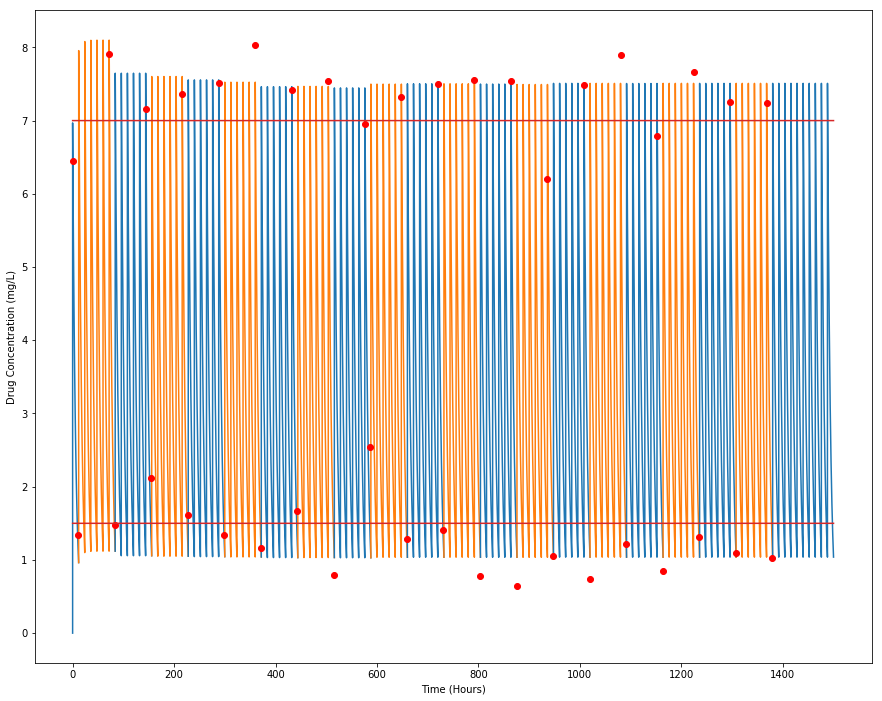

In [10]:
plt.rcParams['figure.figsize'] = (15, 12)

#plt.xticks(np.arange(0, 25, 1.0))
#plt.axvline(x=0, ymin=0, ymax=8)
#plt.axvline(x=11, ymin=0, ymax=8)

ds = DrugSimulator()
ds.graph(k_el, v_d, step=0.1)